### This notebook illustrates how to use the boostPM package.
### Please make sure you are running it in the environment in which the package is installed.

In [1]:
import boostPM.model as boostPM
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pickle as pkl
import gzip
rng = np.random.default_rng()
%load_ext memory_profiler

In [1]:
def train(data, marginal_params, copula_params):
    n, dim = data.shape[0], data.shape[1]
    models = []
    copula_data = np.empty((n, dim))
    for i in range(dim):
        print('start', i)
        marginal_data = np.copy(data[:, i].reshape(n, 1), order='C')
        marginal_model = boostPM.DensityEstimator(dim = 1, \
                                                  max_depth = marginal_params['max_depth'], \
                                                  lr = marginal_params['lr'], \
                                                  n_estimators = marginal_params['n_estimators'], \
                                                  subsample = marginal_params['subsample'], \
                                                  gamma = marginal_params['gamma'])
        marginal_model.fit(marginal_data)
        print('finish fit', i)
        marginal_model.residualize(marginal_data)
        copula_data[:, i] = marginal_data.reshape(n)
        models.append(marginal_model)
    copula_model = boostPM.DensityEstimator(dim = dim, \
                                            max_depth = copula_params['max_depth'], \
                                            lr = copula_params['lr'], \
                                            n_estimators = copula_params['n_estimators'], \
                                            subsample = copula_params['subsample'], \
                                            gamma = copula_params['gamma'])
    copula_model.fit(copula_data)
    models.append(copula_model)

    return models

We first consider a simple 1D example: a gaussian mixture.
The pdf is $$\frac{1}{3}\left(N(-1, 0.2^2) + N(0, 0.3^2) + N(1, 0.1^2)\right).$$

In [2]:
n = 20000
mixture_idx = rng.integers(3, size = n)
loc = [-1., 0., 1.]
scale = [0.2, 0.3, 0.1]
data = np.array([rng.normal(loc=loc[i], scale=scale[i]) for i in mixture_idx]).reshape(n, 1)
data_transformed = 1/(1 + np.exp(-data)) # transform the data into unit hypercube

Now we define and train the model. Change the hyperparameters and see how the performance changes.

In [28]:
model = boostPM.DensityEstimator(dim=1, max_depth=10, lr=0.05, n_estimators = 500, gamma=0.5)
model.fit(data_transformed)

Now let us plot the estimated density and sample from the trained model.

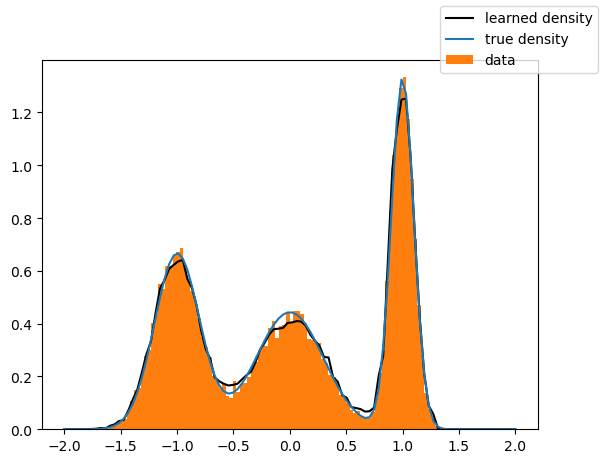

In [29]:
# Plot learned density
x = np.linspace(-2, 2, 100)
x_transformed = 1/(1 + np.exp(-x))
densities_transformed = np.exp(model.eval_log_density(x_transformed.reshape(100, 1))) # eval_log_density method accepts an n x d array, where d is the dimension of the data
densities = densities_transformed * (np.exp(-x))/((1+np.exp(-x))**2) # don't forget the jacobian!
densities_true = (1./3) * (stats.norm.pdf(x, loc=-1., scale=0.2) + stats.norm.pdf(x, loc=0., scale=0.3) + stats.norm.pdf(x, loc=1., scale=0.1))

fig, ax = plt.subplots()

ax.plot(x, densities, label='learned density', c='black')
ax.plot(x, densities_true, label='true density')
ax.hist(data.flatten(), bins=100, density=True, label='data')
fig.legend()
plt.show()

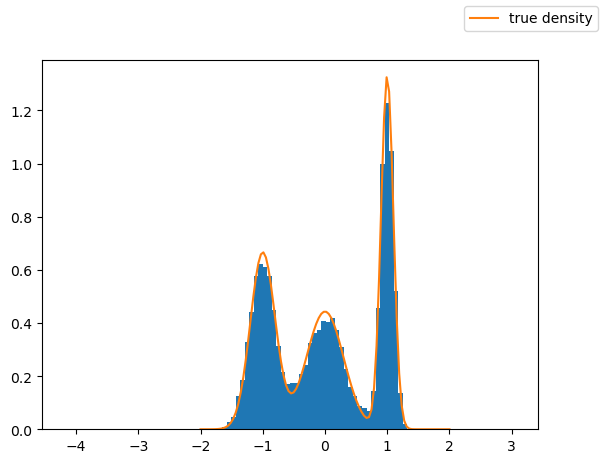

In [35]:
# draw samples from learned distribution

samples = np.array(model.simulate(20000))
samples = np.log(samples/(1-samples)) # transform back to original space

fig, ax = plt.subplots()

ax.hist(samples.flatten(), bins=100, density=True)
ax.plot(x, densities_true, label='true density')
fig.legend()
plt.show()

Now we move to a 2D example. The x and y coordinates will be independently drawn from the following gaussian mixture:
$$\frac{1}{3}\left(N(-1, 0.1^2) + N(0, 0.1^2) + N(1, 0.1^2)\right).$$

In [2]:
n = 100000
mixture_idx = rng.integers(3, size=n)
x = []
for i in range(n):
    x.append(np.random.default_rng().normal(loc=mixture_idx[i]-1, scale=0.1))
x = np.array(x)

mixture_idx = rng.integers(3, size=n)
y = []
for i in range(n):
    y.append(np.random.default_rng().normal(loc=mixture_idx[i]-1, scale=0.1))
y = np.array(y)

gaussian_data = np.vstack((x, y)).T


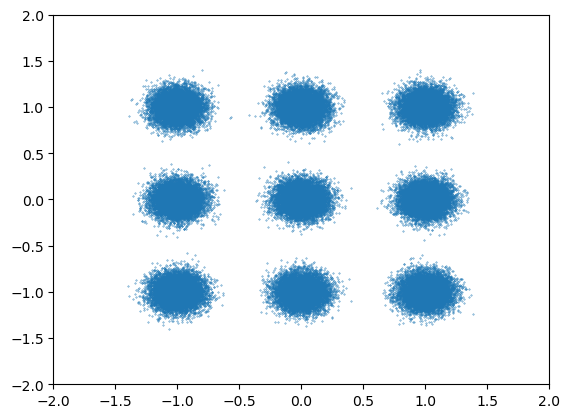

In [64]:
mfig, ax = plt.subplots()

ax.scatter(gaussian_data[:, 0], gaussian_data[:, 1], s=0.1)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
plt.show()

In [4]:
model = boostPM.DensityEstimator(dim=2, max_depth=20, lr=0.05, n_estimators = 1000, subsample=0.5, gamma=0.5)
gaussian_data_transformed = np.ascontiguousarray(1/(1+np.exp(-gaussian_data)))
# model.fit(gaussian_data_transformed)

# marginal_params = {'max_depth': 10, 'lr': 0.1, 'n_estimators': 100, 'subsample': 0.7, 'gamma': 0.1}
# copula_params = {'max_depth': 10, 'lr': 0.1, 'n_estimators': 1000, 'subsample': 0.7, 'gamma': 0.1}

# models = train(gaussian_data_transformed, marginal_params, copula_params)

In [5]:
marginal_data = np.copy(gaussian_data_transformed[:, 1].reshape(100000, 1), order='C')
marginal_model = boostPM.DensityEstimator(dim = 1, \
                                          max_depth = 10, \
                                          lr = 0.1, \
                                          n_estimators = 100, \
                                          subsample = 0.7, \
                                          gamma = 0.1)
marginal_data

array([[0.27850672],
       [0.52427681],
       [0.54068683],
       ...,
       [0.47418869],
       [0.50534038],
       [0.70558799]])

In [6]:
marginal_model.fit(marginal_data)

In [8]:
len(marginal_model.trees)

101

In [19]:
marginal_model.residualize(marginal_data)

: 

In [60]:
X, Y = np.meshgrid(np.linspace(-2, 2, 1000), np.linspace(-2, 2, 1000))
coords = np.vstack((X.ravel(), Y.ravel())).T
coords_transformed = np.ascontiguousarray(1/(1+np.exp(-coords)))
densities2d_transformed = np.exp(model.eval_log_density(coords_transformed))
jac = np.prod(np.exp(-coords)/((1+np.exp(-coords))**2), axis=1)
densities2d = densities2d_transformed * jac

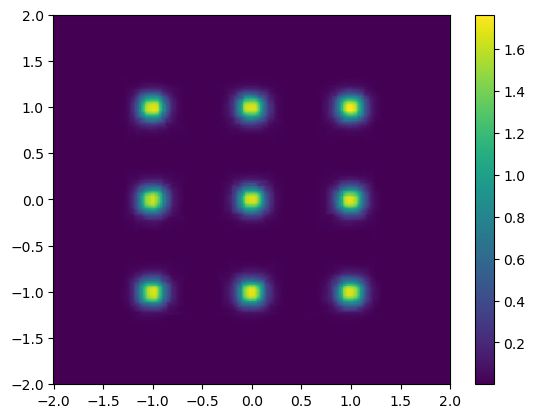

In [65]:
fig, ax = plt.subplots()

fig.colorbar(ax.pcolor(X, Y, densities2d.reshape(1000, 1000)))
plt.show()

In [69]:
with open('mnist.pkl', 'rb') as f:
    mnist_data = pkl.load(f)

UnicodeDecodeError: 'ascii' codec can't decode byte 0x90 in position 614: ordinal not in range(128)

In [3]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    training_data, validation_data, test_data = pkl.load(f, encoding="latin1")

In [33]:
digit = 0
mnist_data = np.vstack((training_data[0][training_data[1] == digit], validation_data[0][validation_data[1] == digit], test_data[0][test_data[1] == digit]))
mnist_data = np.ascontiguousarray(mnist_data.astype(np.float64))

In [34]:
model = boostPM.DensityEstimator(dim=784, max_depth=50, lr=0.1, n_estimators = 500, gamma=0.1)
%memit model.fit(mnist_data)

peak memory: 1392.79 MiB, increment: 72.77 MiB


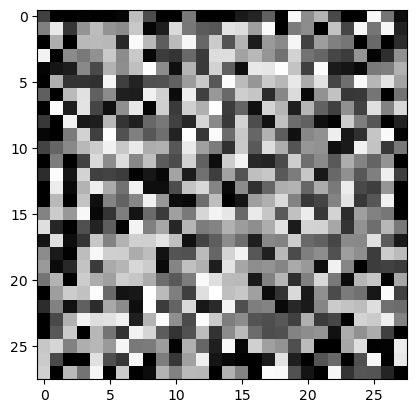

In [47]:
random_digit = np.array(model.simulate(1))[0]
fig, ax = plt.subplots()

ax.imshow(random_digit.reshape(28, 28), cmap='gray')
# ax.imshow(mnist_data[103].reshape(28, 28), cmap='gray')
plt.show()

In [49]:
arr = np.array([[1, 2, 3], [4, 5, 6]])
arr2 = arr[:, 0]
arr2[1] = 20
arr

array([[ 1,  2,  3],
       [20,  5,  6]])

In [51]:
np.empty((10, 2))

array([[0. , 0. ],
       [0.3, 1. ],
       [0. , 0. ],
       [1. , 1. ],
       [1. , 1. ],
       [1. , 1. ],
       [1. , 0. ],
       [0. , 1. ],
       [0.5, 0. ],
       [0. , 1. ]])

In [ ]:
()